In [1]:
# Import all the necessary packages
#import uproot  # check out the documentation about the basics at https://uproot.readthedocs.io/en/latest/basic.html
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import awkward as ak
import datetime as dt
import numpy as np
import vector
import itertools
vector.register_awkward()

In [2]:
#path to parquet files
DATA_DIR = "."
PATHS = list(set(glob.glob(os.path.join(DATA_DIR, '*.parquet'))))

In [3]:
#filtering function
def createFilter(data,minMu,minEl):
    mu_isolation_cut = ak.sum(abs(data.Muon_pfRelIso04_all) < 0.4, axis=1) == minMu
    muon_pt_cut = ak.sum(data.Muon_pt > 5, axis=1) ==minMu
    muon_eta_cut = ak.sum(abs(data.Muon_eta) < 2.4, axis=1) == minMu
    muon_sip_cut = ak.sum(abs(data.Muon_sip3d) < 4, axis=1) == minMu
    muon_dxy_cut = ak.sum(abs(data.Muon_dxy) < 0.5, axis=1) == minMu
    muon_dz_cut = ak.sum(abs(data.Muon_dz) < 1.0, axis=1) == minMu
    mu_cuts = mu_isolation_cut * muon_pt_cut * muon_eta_cut * muon_sip_cut * muon_dxy_cut * muon_dz_cut

    el_isolation_cut = ak.sum(abs(data.Electron_pfRelIso03_all) < 0.4, axis=1) == minEl
    el_pt_cut = ak.sum(data.Electron_pt > 7, axis=1) ==minEl
    el_eta_cut = ak.sum(abs(data.Electron_eta) < 2.5, axis=1) == minEl
    el_sip_cut = ak.sum(abs(data.Electron_sip3d) < 4, axis=1) == minEl
    el_dxy_cut = ak.sum(abs(data.Electron_dxy) < 0.5, axis=1) == minEl
    el_dz_cut = ak.sum(abs(data.Electron_dz) < 1.0, axis=1) == minEl
    el_cuts = el_isolation_cut * el_pt_cut * el_eta_cut * el_sip_cut * el_dxy_cut * el_dz_cut

    return mu_cuts * el_cuts

In [4]:
#this whole thing should be in a loop
inf = [i for i in PATHS if 'SMH' in i][0]
data = ak.from_parquet(inf)

start=dt.datetime.now()
for inf in PATHS:

    #reading the files
    #data=ak.from_parquet(inf)

    # E and mu impact parameters and their significance
    data['Muon_ip3d']=np.sqrt(data.Muon_dxy*data.Muon_dxy + data.Muon_dz*data.Muon_dz)
    data['Muon_sip3d']=data.Muon_ip3d/np.sqrt(data.Muon_dxyErr*data.Muon_dxyErr + data.Muon_dzErr*data.Muon_dzErr)
    data['Electron_ip3d']=np.sqrt(data.Electron_dxy*data.Electron_dxy + data.Electron_dz*data.Electron_dz)
    data['Electron_sip3d']=data.Electron_ip3d/np.sqrt(data.Electron_dxyErr*data.Electron_dxyErr + data.Electron_dzErr*data.Electron_dzErr)

    #using the filtering function
    fourMu    = createFilter(data,4,0)
    twoMuTwoE = createFilter(data,2,2)
    fourEl    = createFilter(data,0,4)

    # .to_list is necessary bc it will include
    # the necessary data with specifying strings 
    # attached. Otherwise hzz...[0] won't work
    # correctly. WARNING: Runs over 4 min!!!
    # Example: 'PV_x': 0.2441709190607071
    hzz4mu   = data[fourMu]#.to_list()
    hzz2e2mu = data[twoMuTwoE]#.to_list()
    hzz4e    = data[fourEl]#.to_list()

    # Sample sizes:
    print("Higgs to ZZ to 4 muons sample size: %i" % len(hzz4mu))
    print("Higgs to ZZ to 2 electrons and 2 muons sample size: %i" % len(hzz2e2mu))
    print("Higgs to ZZ to 4 electrons sample size: %i" % len(hzz4e))
    print(inf)
stop=dt.datetime.now()
print(stop-start)

Higgs to ZZ to 4 muons sample size: 8723
Higgs to ZZ to 2 electrons and 2 muons sample size: 12730
Higgs to ZZ to 4 electrons sample size: 5706
./Run2012C_DoubleElectron.parquet
Higgs to ZZ to 4 muons sample size: 8723
Higgs to ZZ to 2 electrons and 2 muons sample size: 12730
Higgs to ZZ to 4 electrons sample size: 5706
./skim.parquet
Higgs to ZZ to 4 muons sample size: 8723
Higgs to ZZ to 2 electrons and 2 muons sample size: 12730
Higgs to ZZ to 4 electrons sample size: 5706
./ZZTo2e2mu.parquet
Higgs to ZZ to 4 muons sample size: 8723
Higgs to ZZ to 2 electrons and 2 muons sample size: 12730
Higgs to ZZ to 4 electrons sample size: 5706
./ZZTo4mu.parquet
Higgs to ZZ to 4 muons sample size: 8723
Higgs to ZZ to 2 electrons and 2 muons sample size: 12730
Higgs to ZZ to 4 electrons sample size: 5706
./SMHiggsToZZTo4L.parquet
Higgs to ZZ to 4 muons sample size: 8723
Higgs to ZZ to 2 electrons and 2 muons sample size: 12730
Higgs to ZZ to 4 electrons sample size: 5706
./Run2012B_DoubleElectr

In [5]:
hzz4mu[0]

<Record ... Electron_sip3d: []} type='{"run": int32, "luminosityBlock": uint32, ...'>

### Only Muon interactions

In [6]:
start=dt.datetime.now()
hmass = []
z1mass= []
z2mass= []
count = 0
for e in hzz4mu:
    nMuon = e['nMuon'] # How many compnents in muon vector
    mus = []
    for i in range(nMuon):
        mus.append(vector.obj(pt=e['Muon_pt'][i],eta=e['Muon_eta'][i],
                              phi=e['Muon_phi'][i],mass=e['Muon_mass'][i])) # list of vectors
        
    combos = itertools.combinations(range(nMuon),2) # find combinations like (0, 1), (0, 2),...,(2, 3)
    Z_mu_can = []

    for j in combos:                                # in total there are 6 possible combinations bc of 4 comp
        m1 = mus[j[0]] # 1st mass of the combination
        m2 = mus[j[1]] # 2nd mass of the combination
        z = m1 + m2              # sum of the muon masses 
        ch1 = e['Muon_charge'][j[0]] # 1st charge of the combination
        ch2 = e['Muon_charge'][j[1]] # 2nd charge of the combination
        if not (ch1 + ch2): # '+/-' and '+/-' not possible, only '+' and '-'
            count = count + 1
            Z_mu_can.append([z.mass,j[0],j[1]]) # find leptons with different charge combinations 
    #print(Z_mu_can)                     # and write into a list named 'massMuon'
    zbest = 0
    best = 9999 #sufficiently large that is bigger than 91
    zother=[]
    for z_vec in Z_mu_can:
        d = abs(z_vec[0] - 91.)
        if d < best:
            zbest = z_vec   # chooses best Z1 [93.66, 2, 3]
            best = d        # last two indecies give a hint about z2 values

    if not sum(e['Muon_charge']): # meaning charge vector needs to be eq. to 0
        idx = [i for i in range(nMuon) if i not in zbest[1:]]    # if z1 [2,3] then z2 [0,1]
        zother = [i for i in Z_mu_can if idx[0]==i[1] and idx[1]==i[2]][0]
        hmass.append((mus[0] + mus[1] + mus[2] + mus[3]).mass) #Higgs # for elmu (mus[0] + mus[1] + mel[0] + mus[1]).mass
        z1mass.append(zbest[0])     # mus[0] + mus[1] but needs a condition that it is closer to 91 GeV
        z2mass.append(zother[0])    # el[0] + el[1] but vice versa.
    #print(zbest,'\t', zother)



stop=dt.datetime.now()
#print(count)      # how many components are in massMuon
#print(zbest)
print(stop-start)


0:00:47.879222


In [7]:
sigma = 106.7 #fb, calculated by theorists
L     = 11.58 #fb^-1 luminocity, determined by the machine
N_ent = 1499064
w = sigma*L/N_ent
df_mu = pd.DataFrame({"higgs":hmass, "Z1":z1mass, "Z2":z2mass, "weight":w})
df_mu.head()


,higgs,Z1,Z2,weight
0,125.123040,93.663402,7.725514,0.000824
1,123.906535,58.027074,54.522374,0.000824
2,125.260717,77.300505,37.468496,0.000824
3,124.775946,76.583284,39.096827,0.000824
4,124.205550,64.765260,16.999576,0.000824


In [8]:
#e.to_list()

### Only Electron interactions

In [9]:
start=dt.datetime.now()
hmass_el = []
z1mass_el= []
z2mass_el= []
count = 0
for e in hzz4e:
    nElec = e['nElectron'] # How many compnents in muon vector
    elec = []
    for i in range(nElec):
        elec.append(vector.obj(pt=e['Electron_pt'][i],eta=e['Electron_eta'][i],
                              phi=e['Electron_phi'][i],mass=e['Electron_mass'][i])) # list of vectors
        
    combos = itertools.combinations(range(nElec),2) # find combinations like (0, 1), (0, 2),...,(2, 3)
    Z_el_can = []

    for j in combos:                                # in total there are 6 possible combinations bc of 4 comp
        m1 = elec[j[0]] # 1st mass of the combination
        m2 = elec[j[1]] # 2nd mass of the combination
        z = m1 + m2              # sum of the muon masses 
        ch1 = e['Electron_charge'][j[0]] # 1st charge of the combination
        ch2 = e['Electron_charge'][j[1]] # 2nd charge of the combination
        if not (ch1 + ch2): # '+/-' and '+/-' not possible, only '+' and '-'
            #count = count + 1
            Z_el_can.append([z.mass,j[0],j[1]]) # find leptons with different charge combinations 
    #print(Z_mu_can)                     # and write into a list named 'massMuon'
    zbest = 0
    best = 9999 #sufficiently large that is bigger than 91
    zother=[]
    for z_vec in Z_el_can:
        d = abs(z_vec[0] - 91.)
        if d < best:
            zbest = z_vec   # chooses best Z1 [93.66, 2, 3]
            best = d        # last two indecies give a hint about z2 values

    if not sum(e['Electron_charge']): # meaning charge vector needs to be eq. to 0
        idx = [i for i in range(nElec) if i not in zbest[1:]]    # if z1 [2,3] then z2 [0,1]
        zother = [i for i in Z_el_can if idx[0]==i[1] and idx[1]==i[2]][0]
        hmass_el.append((elec[0] + elec[1] + elec[2] + elec[3]).mass) #Higgs # for elmu (mus[0] + mus[1] + mel[0] + mus[1]).mass
        z1mass_el.append(zbest[0])     # mus[0] + mus[1] but needs a condition that it is closer to 91 GeV
        z2mass_el.append(zother[0])    # el[0] + el[1] but vice versa.
    #print(zbest,'\t', zother)
stop=dt.datetime.now()
#print(count)      # how many components are in massMuon
#print(zbest)
print(stop-start)


0:00:33.313267


In [10]:
#sigma = 106.7 #fb, calculated by theorists
#L     = 11.58 #fb^-1 luminocity, determined by the machine
print(len(hmass_el),len(z1mass_el),len(z2mass_el))
N_ent_el = 1499093
w_el = sigma*L/N_ent_el
df_el = pd.DataFrame({"higgs":hmass_el, "Z1":z1mass_el, "Z2":z2mass_el, "weight":w_el})
df_el.head()

5598 5598 5598


,higgs,Z1,Z2,weight
0,123.171802,76.752531,39.070825,0.000824
1,123.002380,89.996619,24.098241,0.000824
2,128.669305,76.454656,41.133385,0.000824
3,107.587129,73.297194,30.070214,0.000824
4,128.919869,97.334217,28.285901,0.000824


### Electron and Muon Interactions

In [11]:
#hzz2e2mu.to_list()

In [12]:
start=dt.datetime.now()
hmass_elmu = []
z1mass_elmu= []
z2mass_elmu= []
count = 0
for e in hzz2e2mu:
    nElMu = e['nMuon'] # How many compnents in muon vector
    mu = []
    el = []
    for i in range(nElMu):
        mu.append(vector.obj(pt=e['Muon_pt'][i],eta=e['Muon_eta'][i],
                              phi=e['Muon_phi'][i],mass=e['Muon_mass'][i]))
        el.append(vector.obj(pt=e['Electron_pt'][i],eta=e['Electron_eta'][i],
                              phi=e['Electron_phi'][i],mass=e['Electron_mass'][i]))
    
    z_mu = mu[0] + mu[1]
    z_el = el[0] + el[1]
    if not sum(e['Muon_charge']) and not sum(e['Electron_charge']): # meaning charge vector needs to be eq. to 0
        hmass_elmu.append((z_el + z_mu).mass) #Higgs # for elmu (mus[0] + mus[1] + mel[0] + mus[1]).mass
        if abs(z_el.mass - 91) < abs(z_mu.mass-91):
            z1mass_elmu.append(z_el.mass)     # mus[0] + mus[1] but needs a condition that it is closer to 91 GeV
            z2mass_elmu.append(z_mu.mass)    # el[0] + el[1] but vice versa.
        else:
            z1mass_elmu.append(z_mu.mass)
            z2mass_elmu.append(z_el.mass)

    #print(zbest,'\t', zother)
stop=dt.datetime.now()
#print(count)      # how many components are in massMuon
#print(zbest)
print(stop-start)


0:00:32.473730


In [13]:
print(len(hmass_elmu),len(z1mass_elmu),len(z2mass_elmu))

12612 12612 12612


In [14]:
N_ent_elmu = 1497445
w_elmu = sigma*L/N_ent_elmu
df_elmu = pd.DataFrame({"higgs":hmass_elmu, "Z1":z1mass_elmu, "Z2":z2mass_elmu, "weight":w_elmu})
df_elmu.head()

,higgs,Z1,Z2,weight
0,127.204983,89.203033,27.516144,0.000825
1,125.234140,90.285635,22.878929,0.000825
2,124.515146,89.532225,32.973686,0.000825
3,124.721181,90.901835,21.138948,0.000825
4,125.586828,87.333601,30.304454,0.000825


(array([7.42616523e-03, 9.90155365e-03, 1.23769421e-02, 1.73277189e-02,
        1.56774599e-02, 1.89779778e-02, 1.65025894e-02, 1.32020715e-02,
        1.56774599e-02, 2.55790136e-02, 3.21800494e-02, 6.84857461e-02,
        9.65401481e-02, 2.14533662e-01, 5.87492183e-01, 2.79636378e+00,
        5.60510449e+00, 7.21163157e-01, 7.50867818e-02, 1.98031073e-02,
        6.60103576e-03, 2.47538841e-03, 2.47538841e-03, 0.00000000e+00,
        8.25129471e-04, 1.65025894e-03, 1.65025894e-03, 1.65025894e-03,
        0.00000000e+00, 0.00000000e+00, 1.65025894e-03, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00]),
 array([ 60,  64,  68,  72,  76,  80,  84,  88,  92,  96, 100, 104, 108,
        112, 116, 120, 124, 128, 132, 136, 140, 144, 148, 152, 156, 160,
        164, 168, 172, 176, 180, 184, 188, 192, 196]),
 <BarContainer object of 34 artists>)

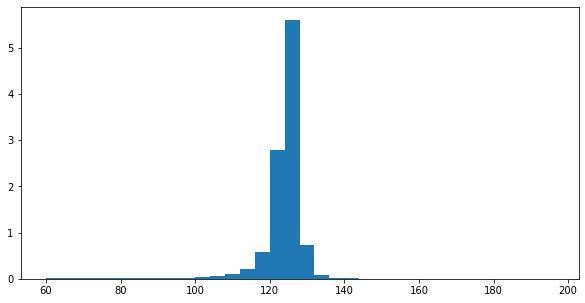

In [17]:
plt.rcParams['figure.figsize'] = [10,5]
plt.hist(df_elmu.higgs, bins=range(60,200,4),weights=df_elmu.weight)

(0.0, 70.0)

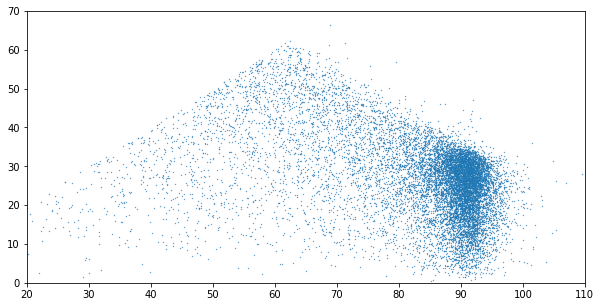

In [19]:
plt.scatter(df_elmu.Z1, df_elmu.Z2,s=0.1)
plt.xlim(20,110)
plt.ylim(0,70)

Text(0, 0.5, 'N events / 5 GeV')

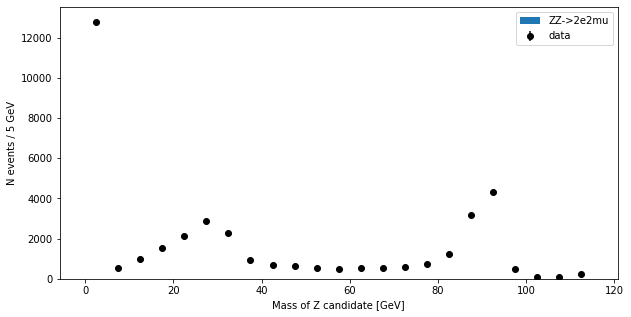

In [30]:
bins = range(0,120,5)
binCenters=[(bins[i]+bins[i+1])/2 for i in range(len(bins)-1)]

plt.hist(df_elmu.Z1, weights=df_elmu.weight,bins=bins,label='ZZ->2e2mu')
dd = df_elmu.higgs.tolist() + df_elmu.Z1.tolist()+df_elmu.Z2.to_list()+df_elmu.weight.to_list()
data = np.histogram(dd,bins=bins)
plt.errorbar(binCenters,data[0], yerr=np.sqrt(data[0]), fmt='o', c='black',label='data')
plt.legend()
plt.xlabel('Mass of Z candidate [GeV]')
plt.ylabel('N events / 5 GeV')

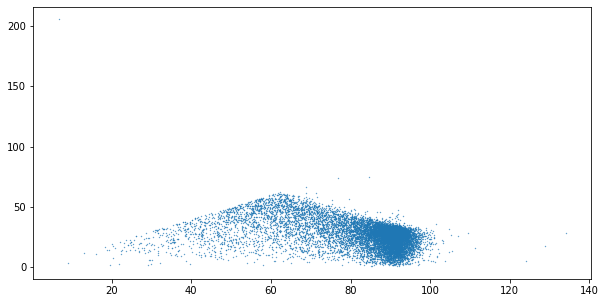

In [29]:
plt.scatter(df_elmu.Z1,df_elmu.Z2,s=0.1,label='ZZ')

plt.xlim(20,110)
plt.ylim(0,70)

In [15]:
# Function to find element
# closest to given target.
# LINK: https://stackoverflow.com/questions/2566412/find-nearest-value-in-numpy-array
# Returns element closest to target in array
def find_nearest(array, target):
    array = np.asarray(array)
    idx = (np.abs(array - target)).argmin()
    return array[idx]